<a href="https://colab.research.google.com/github/lrochaqu/nyu-python-public-policy/blob/master/hw_4_lauraR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NYU Wagner - Python Coding for Public Policy**
# Starter notebook for HW 4: Analyzing and visualizing specific categories of 311 complaints

## Start by importing necessary packages

In [0]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from google.colab import drive

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Read and save our cleaned 311 Service Requests dataset as a pandas dataframe named "df"

In [147]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Data for Python/cleaned_311_data.csv', header='infer')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,18,21,32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## **Problem Statement:** 
There seems to be a general trend that the higher the community district population, the higher the number of 311 requests. However, there is a lot of variance in the data. What if we only look at complaint types that are likely influenced by population?

"Noise - Residential" and "HEAT/HOT WATER" were the most frequest requests in the entire 311 dataset. Let's try isolating the count of requests in each of those two categories versus all the other complaints.

**Step 1**. First you will need to prep your data to get the count of complaints categorized as Noise - Residential, HEAT/HOT WATER, and everything else. You can update the code from lecture that gets the total count of 311 requests per CD to instead get the count of 311 requests per CD that meet the criteria for the 3 categories. You should create three separate dataframes, one per category:

1. `complaint_type = 'Noise - Residential'`
2. `complaint_type = 'HEAT/HOT WATER'`
3. Everything else: `(complaint_type != 'Noise - Residential') & (complaint_type != 'HEAT/HOT WATER')`

First create 3 dataframes, that contain the desired rows based on the complaint_type row filtering.

In [0]:
noise = df[df.complaint_type == 'Noise - Residential']
heatwater = df[df.complaint_type == 'HEAT/HOT WATER']
other = df[(df.complaint_type != 'HEAT/HOT WATER') & (df.complaint_type != 'Noise - Residential')]

Then group each dataframes by the `community_board` value to get the count of request per community district.

In [149]:
count_noise = noise.groupby('community_board').size().reset_index(name='count_of_311_requests')
print(len(count_noise))

count_heatwater = heatwater.groupby('community_board').size().reset_index(name='count_of_311_requests')
print(len(count_heatwater))

count_other = other.groupby('community_board').size().reset_index(name='count_of_311_requests')
print(len(count_other))

# note: we won't use count_all in the charts, but we can use it as a check that the subsets all add up to the correct total
count_all = df.groupby('community_board').size().reset_index(name='count_of_311_requests')
print(len(count_all))

69
66
77
77


Note the lengths of these dataframes. We can see that we're going to run into problems, because they're each a different length (i.e. have a different number of rows) and they're all greater than 59. There are only 59 community districts in the city, so these dataframes are including some extra invalid community district rows. The invalid rows include community board values containing "Unspecified" or district numbers that are higher than what exist in real life. Ex: '84 QUEENS', 'Unspecified BRONX'


Here's a list of all the valid borocd values that exist in the city:

In [0]:
valid_borocds = ['101','102','103','104','105','106','107','108','109','110','111','112','201','202','203','204','205','206','207','208','209','210','211','212','301','302','303','304','305','306','307','308','309','310','311','312','313','314','315','316','317','318','401','402','403','404','405','406','407','408','409','410','411','412','413','414','501','502','503']

If we recode the community_board column into borocd, we can filter our dataframes to only keep valid borocd rows

In [0]:
# this function will recode the community_board value into borocd in a new column

def recode_borocd_counts(row):
  if row.community_board[0] != 'U':
    if 'MANHATTAN' in row.community_board:
      return '1' + row.community_board[0:2]
    elif 'BRONX' in row.community_board:
      return '2' + row.community_board[0:2]
    elif 'BROOKLYN' in row.community_board:
      return '3' + row.community_board[0:2]
    elif 'QUEENS' in row.community_board:
      return '4' + row.community_board[0:2]
    elif 'STATEN ISLAND' in row.community_board:
      return '5' + row.community_board[0:2]
  else:
    return 'Invalid borocd'

# we can apply the function to each of our dataframes. this is the beauty of functions; you can reuse them on multiple objects!

count_noise['borocd'] = count_noise.apply(recode_borocd_counts, axis=1)

count_heatwater['borocd'] = count_heatwater.apply(recode_borocd_counts, axis=1)

count_other['borocd'] = count_other.apply(recode_borocd_counts, axis=1)

count_all['borocd'] = count_all.apply(recode_borocd_counts, axis=1)

Now we can filter the dataframes to only keep the valid borocd rows. Remember the `.isin()` function from one of our prior lectures?

In [152]:
count_noise = count_noise[count_noise.borocd.isin(valid_borocds)]
print(len(count_noise))

count_heatwater = count_heatwater[count_heatwater.borocd.isin(valid_borocds)]
print(len(count_heatwater))

count_other = count_other[count_other.borocd.isin(valid_borocds)]
print(len(count_other))

count_all = count_all[count_all.borocd.isin(valid_borocds)]
print(len(count_all))

59
59
59
59


Great, now we have clean dataframes that are all the same, correct length. Let's make sure the 311 request counts add up as expected.

In [153]:
print(count_noise.head())
print(count_heatwater.head())
print(count_other.head())
print(count_all.head())

    community_board  count_of_311_requests borocd
1          01 BRONX                   3691    201
2       01 BROOKLYN                   5844    301
3      01 MANHATTAN                    722    101
4         01 QUEENS                   4589    401
5  01 STATEN ISLAND                   5052    501
    community_board  count_of_311_requests borocd
0          01 BRONX                   3346    201
1       01 BROOKLYN                   2868    301
2      01 MANHATTAN                    276    101
3         01 QUEENS                   2466    401
4  01 STATEN ISLAND                   1644    501
    community_board  count_of_311_requests borocd
1          01 BRONX                  20316    201
2       01 BROOKLYN                  59389    301
3      01 MANHATTAN                  20261    101
4         01 QUEENS                  53370    401
5  01 STATEN ISLAND                  58449    501
    community_board  count_of_311_requests borocd
1          01 BRONX                  27353    201


In [154]:
27353 == 20316 + 3346 + 3691

True

Everything adds up, and we're ready to start Step 2

**Step 2**. Create a stacked bar chart of 311 requests per community district. Each community district bar should be comprised of three stacked bars, one for each category listed below. The total height of each community district bar (the sum of the three stacked bars) should reflect the total count of 311 complaints per community district.
- number of `'Noise - Residential'` complaints per community district
- number of `'HEAT/HOT WATER'` complaints per community district
- number of other complaints per community district 

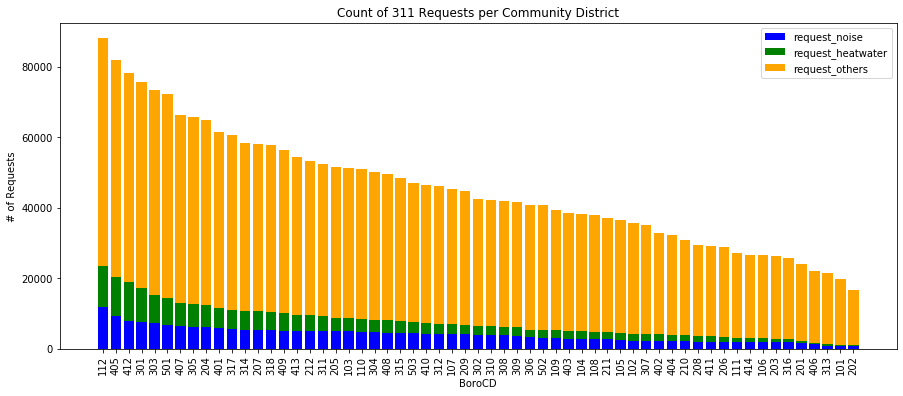

In [155]:

position_on_x = np.arange(len(count_all))
counts_noise = np.array(count_noise.sort_values(by='count_of_311_requests', ascending=False).count_of_311_requests)
counts_heatwater = np.array(count_heatwater.sort_values(by='count_of_311_requests', ascending=False).count_of_311_requests)
counts_others = np.array(count_other.sort_values(by='count_of_311_requests', ascending=False).count_of_311_requests)
bars = np.add(counts_noise,counts_heatwater).tolist()
plt.figure(figsize=(15, 6))
plot1 = plt.bar(
  position_on_x,
  counts_noise,
  align='center',
  color='blue',
  label='request_noise'
)
plot2 = plt.bar(
  position_on_x,
  counts_heatwater,
  bottom=counts_noise,
  align='center',
  color='green',
  label='request_heatwater'
)
plot3 = plt.bar(
  position_on_x,
  counts_others,
  bottom=bars,
  align='center',
  color='orange',
  label='request_others'
)
plt.xticks(position_on_x, count_all.sort_values(by='count_of_311_requests', ascending=False).borocd, rotation=90)
plt.title('Count of 311 Requests per Community District')
plt.xlabel('BoroCD')
plt.ylabel('# of Requests')
plt.legend() 

plt.show()




In [156]:
counts_heatwater 


array([11692, 11203, 10942,  9555,  7737,  7536,  6448,  6322,  6191,
        5566,  5460,  5426,  5373,  5259,  4944,  4416,  4412,  4204,
        3872,  3761,  3741,  3605,  3548,  3346,  3170,  3068,  2868,
        2694,  2537,  2496,  2466,  2397,  2364,  2136,  2127,  2113,
        2036,  2035,  2018,  1954,  1936,  1927,  1845,  1760,  1759,
        1671,  1649,  1644,  1395,  1189,  1156,  1152,  1008,   864,
         676,   429,   401,   276,   208])

In [157]:
counts_noise

array([11755,  9207,  7898,  7659,  7407,  6819,  6394,  6272,  6119,
        5844,  5585,  5227,  5225,  5213,  5052,  5048,  5037,  4953,
        4911,  4884,  4736,  4589,  4586,  4429,  4406,  4297,  4238,
        4238,  4068,  3881,  3871,  3795,  3691,  3276,  3168,  3161,
        2872,  2848,  2710,  2702,  2429,  2305,  2283,  2279,  2118,
        2078,  1974,  1948,  1939,  1901,  1884,  1837,  1837,  1835,
        1592,  1188,   810,   741,   722])

**Step 3**. Using the same three dataframes created in Step 1, create a scatter plot of community district population (x-axis) vs. community district 311 counts (y-axis) split out by complaint category (noise, heat/water, other). The scatter plot should show the counts of each of the three complaint categories in a different color.

In [158]:
population = pd.read_csv('https://data.cityofnewyork.us/api/views/xi7c-iiu2/rows.csv?accessType=DOWNLOAD', header='infer')
population.head()

,Borough,CD Number,CD Name,1970 Population,1980 Population,1990 Population,2000 Population,2010 Population
0,Bronx,1,"Melrose, Mott Haven, Port Morris",138557,78441,77214,82159,91497
1,Bronx,2,"Hunts Point, Longwood",99493,34399,39443,46824,52246
2,Bronx,3,"Morrisania, Crotona Park East",150636,53635,57162,68574,79762
3,Bronx,4,"Highbridge, Concourse Village",144207,114312,119962,139563,146441
4,Bronx,5,"University Hts., Fordham, Mt. Hope",121807,107995,118435,128313,128200


In [0]:
def recode_borocd_pop(row):
  if row.Borough == 'Manhattan':
    return str(100 + row['CD Number'])
  elif row.Borough == 'Bronx':
    return str(200 + row['CD Number'])
  elif row.Borough == 'Brooklyn':
    return str(300 + row['CD Number'])
  elif row.Borough == 'Queens':
    return str(400 + row['CD Number'])
  elif row.Borough == 'Staten Island':
    return str(500 + row['CD Number'])
  else:
    return 'Invalid borocd'

In [0]:
population['borocd'] = population.apply(recode_borocd_pop, axis=1)
count_heatwater['borocd'] = count_heatwater['borocd'].astype(str)
count_noise['borocd'] = count_noise['borocd'].astype(str)
count_other['borocd'] = count_other['borocd'].astype(str)

In [0]:
pop_heatwater = population.merge(count_heatwater,on='borocd')
pop_noise = population.merge(count_noise,on='borocd')
pop_other = population.merge(count_other,on='borocd')


In [164]:
pop_heatwater.head(10)

,Borough,CD Number,CD Name,1970 Population,1980 Population,1990 Population,2000 Population,2010 Population,borocd,community_board,count_of_311_requests
0,Bronx,1,"Melrose, Mott Haven, Port Morris",138557,78441,77214,82159,91497,201,01 BRONX,3346
1,Bronx,2,"Hunts Point, Longwood",99493,34399,39443,46824,52246,202,02 BRONX,2364
2,Bronx,3,"Morrisania, Crotona Park East",150636,53635,57162,68574,79762,203,03 BRONX,3761
3,Bronx,4,"Highbridge, Concourse Village",144207,114312,119962,139563,146441,204,04 BRONX,10942
4,Bronx,5,"University Hts., Fordham, Mt. Hope",121807,107995,118435,128313,128200,205,05 BRONX,9555
5,Bronx,6,"East Tremont, Belmont",114137,65016,68061,75688,83268,206,06 BRONX,4944
6,Bronx,7,"Bedford Park, Norwood, Fordham",113764,116827,128588,141411,139286,207,07 BRONX,11203
7,Bronx,8,"Riverdale, Kingsbridge, Marble Hill",103543,98275,97030,101332,101731,208,08 BRONX,4412
8,Bronx,9,"Soundview, Parkchester",166442,167627,155970,167859,172298,209,09 BRONX,5426
9,Bronx,10,"Throgs Nk., Co-op City, Pelham Bay",84948,106516,108093,115948,120392,210,10 BRONX,1760


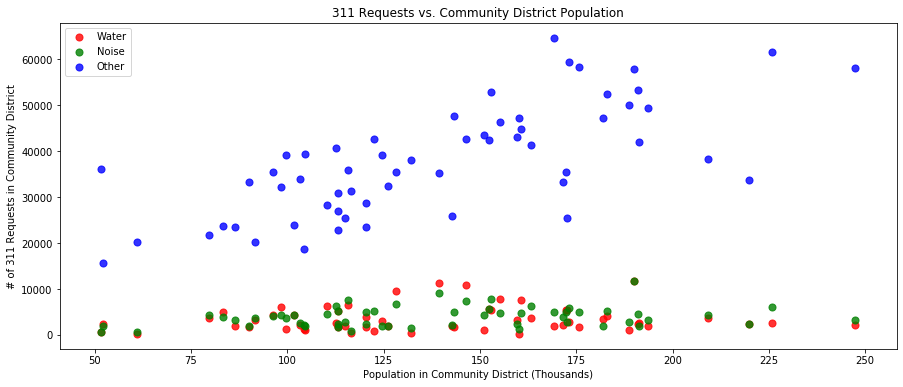

In [170]:
# define the color to be used for the markers for each data subset group
colors = ["red", "green", "blue"]

# define the labels to be used for the data subset group
groups = ["Water", "Noise", "Other"]

plt.figure(figsize=(15,6))

plt.scatter(
  pop_heatwater["2010 Population"]/1000,
  pop_heatwater["count_of_311_requests"],
  alpha=0.8,
  c=colors[0],
  s=50,
  label=groups[0]
)
# each new plot gets rendered on top of the previous one

plt.scatter(
  pop_noise["2010 Population"]/1000,
  pop_noise["count_of_311_requests"],
  alpha=0.8,
  c=colors[1],
  s=50,
  label=groups[1]
)
plt.scatter(
  pop_other["2010 Population"]/1000,
  pop_other["count_of_311_requests"],
  alpha=0.8,
  c=colors[2],
  s=50,
  label=groups[2]
)

plt.title('311 Requests vs. Community District Population')
plt.xlabel('Population in Community District (Thousands)')
plt.ylabel('# of 311 Requests in Community District')

plt.legend(loc=2)

plt.show()

Does it seem like there's a positive correlation between population and noise complaints or population and heat/water complaints? What's a possible explanation for the relationship or lack of relationship?

Yes, there is a correlation between  population and the number of complaints as there are more people complaining about the issue